# Assignment 4: Customer Segmentation with Clustering

**Student Name:** [Your Name Here]

**Date:** [Date]

---

## Assignment Overview

You've been hired as a data science consultant by a UK-based online gift retailer. They're spending the same amount on marketing to all customers regardless of value. Your task: segment their customer base using transaction data from 2009-2011, identify distinct customer groups, and provide actionable recommendations for each segment.

---

## Step 1: Import Libraries and Load Data

In [11]:
pip install pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [15]:
# Load the Online Retail II dataset
# TODO: Load online_retail_II.csv from the data folder
df = pd.read_csv('online_retail_II.csv')  # Replace with pd.read_csv()

# Display basic information
# TODO: Display the first few rows and basic info about the dataset
print("First 10 Rows")
print(df.head(10))
print()

print("Basic Info")
df.info()

print("\n" + "="*80)
print("CHECKPOINT: Verify dataset loaded correctly")
print(f"Dataset shape: {df.shape if df is not None else 'Not loaded'}")
print(f"Date range: [Check InvoiceDate column]")
print("="*80)

First 10 Rows
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
5  489434     22064           PINK DOUGHNUT TRINKET POT         24   
6  489434     21871                  SAVE THE PLANET MUG        24   
7  489434     21523   FANCY FONT HOME SWEET HOME DOORMAT        10   
8  489435     22350                            CAT BOWL         12   
9  489435     22349       DOG BOWL , CHASING BALL DESIGN        12   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75   

---
## Step 2: Aggregate Transaction Data to Customer-Level RFM Features

### Clean Transaction Data

Before aggregating to customer-level, clean the transaction data:
- Remove rows with missing Customer ID
- Remove returns (negative Quantity)
- Create TotalSpend column (Quantity × Price)
- Convert InvoiceDate to datetime

In [16]:
# Clean the data
# TODO: Remove rows with missing Customer IDs
df = df.dropna(subset=['Customer ID'])

# TODO: Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# TODO: Create TotalSpend column
df['TotalSpend'] = df['Quantity'] * df['Price']

# TODO: Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


print("\n" + "="*80)
print("CHECKPOINT: After data cleaning")
print(f"Remaining transactions: {len(df) if df is not None else 'N/A'}")
print(f"Unique customers: {df['Customer ID'].nunique() if df is not None else 'N/A'}")
print("="*80)


CHECKPOINT: After data cleaning
Remaining transactions: 805620
Unique customers: 5881


### Calculate RFM Features for Each Customer

Create three features for each customer:
- **Recency**: Days since last purchase (use December 10, 2011 as reference date)
- **Frequency**: Total number of unique invoices
- **Monetary**: Total amount spent

In [17]:
# Set reference date for recency calculation
reference_date = pd.to_datetime('2011-12-10')

# TODO: For each Customer ID, calculate:
# - Recency: (reference_date - max(InvoiceDate)).days
# - Frequency: count of unique Invoice numbers
# - Monetary: sum of TotalSpend

rfm_df = (df.groupby('Customer ID').agg(Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),Frequency=('Invoice', 'nunique'),Monetary=('TotalSpend', 'sum')).reset_index())
# Replace with aggregated DataFrame

print("\n" + "="*80)
print("CHECKPOINT: RFM Features Created")
if rfm_df is not None:
    print(f"Number of customers: {len(rfm_df)}")
    print(f"\nRFM Summary Statistics:")
    print(rfm_df.describe())
print("="*80)


CHECKPOINT: RFM Features Created
Number of customers: 5881

RFM Summary Statistics:
        Customer ID      Recency    Frequency       Monetary
count   5881.000000  5881.000000  5881.000000    5881.000000
mean   15314.674205   200.992858     6.287196    3017.076888
std     1715.429759   209.489651    13.012879   14734.128619
min    12346.000000     0.000000     1.000000       0.000000
25%    13833.000000    25.000000     1.000000     347.800000
50%    15313.000000    95.000000     3.000000     897.620000
75%    16797.000000   379.000000     7.000000    2304.180000
max    18287.000000   738.000000   398.000000  608821.650000


---
## Step 3: Standardize Features and Determine Optimal k

### Standardize RFM Features

K-means is sensitive to feature scale, so standardize features to mean=0, std=1

In [18]:
# TODO: Use StandardScaler to standardize Recency, Frequency, and Monetary
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])  # Replace with scaled features

print("\n" + "="*80)
print("CHECKPOINT: Features Standardized")
if rfm_scaled is not None:
    print(f"Scaled features shape: {rfm_scaled.shape}")
    print(f"Mean of scaled features: {rfm_scaled.mean(axis=0)}")
    print(f"Std of scaled features: {rfm_scaled.std(axis=0)}")
print("="*80)


CHECKPOINT: Features Standardized
Scaled features shape: (5881, 3)
Mean of scaled features: [ 9.18232408e-17 -2.77886123e-17  2.41640107e-18]
Std of scaled features: [1. 1. 1.]


### Elbow Method: Test k from 2 to 10

Calculate inertia (within-cluster sum of squares) for different values of k

In [20]:
# TODO: Test k values from 2 to 10
# For each k:
#   - Train KMeans(n_clusters=k, random_state=42)
#   - Store inertia value'
from sklearn.cluster import KMeans

inertias = []
k_range = range(2, 11)

# Your code here
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

print("\n" + "="*80)
print("CHECKPOINT: Elbow Method Calculated")
print(f"Tested k values: {list(k_range)}")
print("="*80)


CHECKPOINT: Elbow Method Calculated
Tested k values: [2, 3, 4, 5, 6, 7, 8, 9, 10]


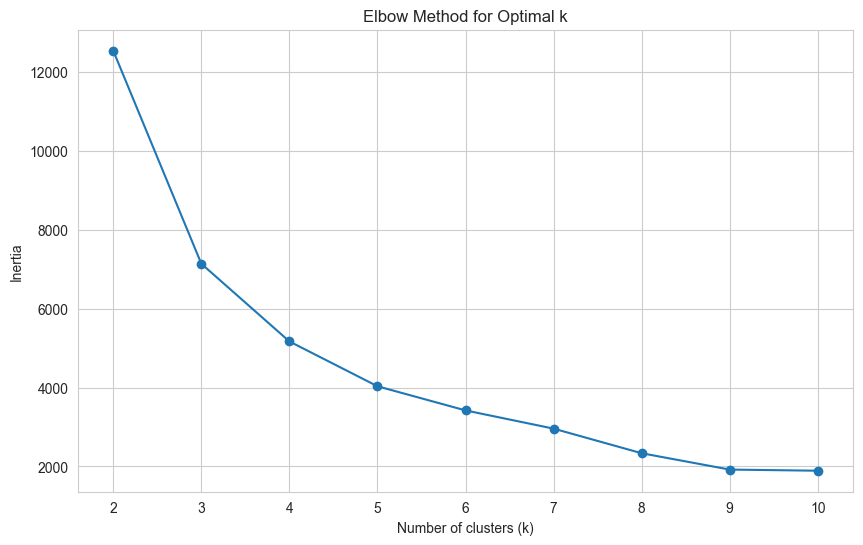

In [21]:
# TODO: Plot the elbow curve
# x-axis: k values
# y-axis: inertia

# Plots 
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


### Silhouette Score Analysis

Calculate silhouette scores to validate cluster quality

In [22]:
# TODO: Calculate silhouette scores for k from 2 to 10
# For each k:
#   - Train KMeans
#   - Calculate silhouette_score(rfm_scaled, labels)

silhouette_scores = []

# Your code here
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

print("\n" + "="*80)
print("CHECKPOINT: Silhouette Scores Calculated")
print("="*80)


CHECKPOINT: Silhouette Scores Calculated


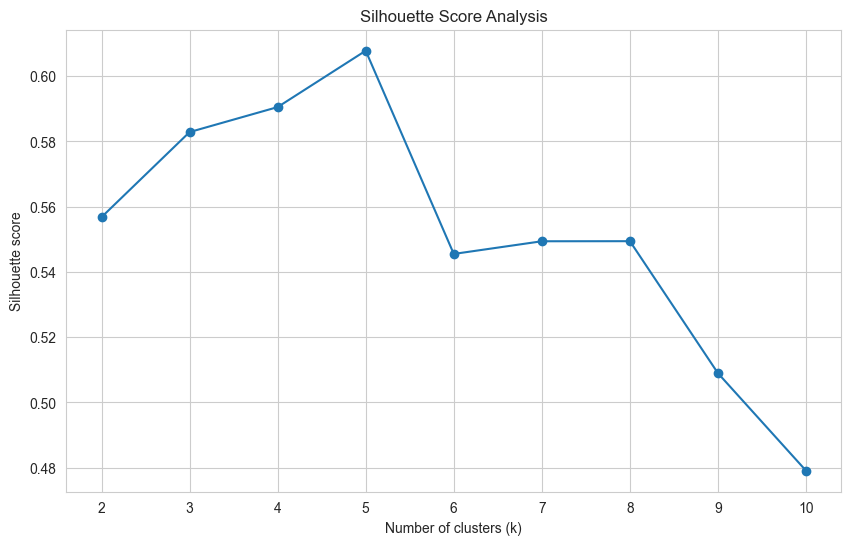

In [23]:
# TODO: Plot silhouette scores
# x-axis: k values
# y-axis: silhouette score

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score Analysis')
plt.show()


### Select Optimal k

**Your k selection justification (write 2-3 sentences):**

I selected k = 5 because it represents the absolute maximum silhouette score, showing the strongest overall cluster separation. While k = 4 has a slightly lower silhouette score, it is still relatively high and suggests a good balance between cluster quality and model simplicity. This places the optimal range around k = 4–5, with k = 5 offering the best clustering performance.

In [24]:
# TODO: Set your chosen k value
optimal_k = 5  # Replace with your chosen k (e.g., 4, 5, or 6)

print(f"Chosen k value: {optimal_k}")

Chosen k value: 5


---
## Step 4: Train K-Means Model and Visualize Segments

### Train Final K-Means Model

In [25]:
# TODO: Train KMeans with your optimal_k and random_state=42
kmeans = KMeans(n_clusters=optimal_k, random_state=42)   # Replace with trained model
# TODO: Add cluster labels to rfm_df
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)


print("\n" + "="*80)
print("CHECKPOINT: K-Means Model Trained")
print(f"Number of clusters: {optimal_k}")
if 'Cluster' in rfm_df.columns:
    print(f"\nCluster sizes:")
    print(rfm_df['Cluster'].value_counts().sort_index())
print("="*80)


CHECKPOINT: K-Means Model Trained
Number of clusters: 5


### Visualize Customer Segments

Create a 2D scatter plot showing Frequency vs Monetary, colored by cluster

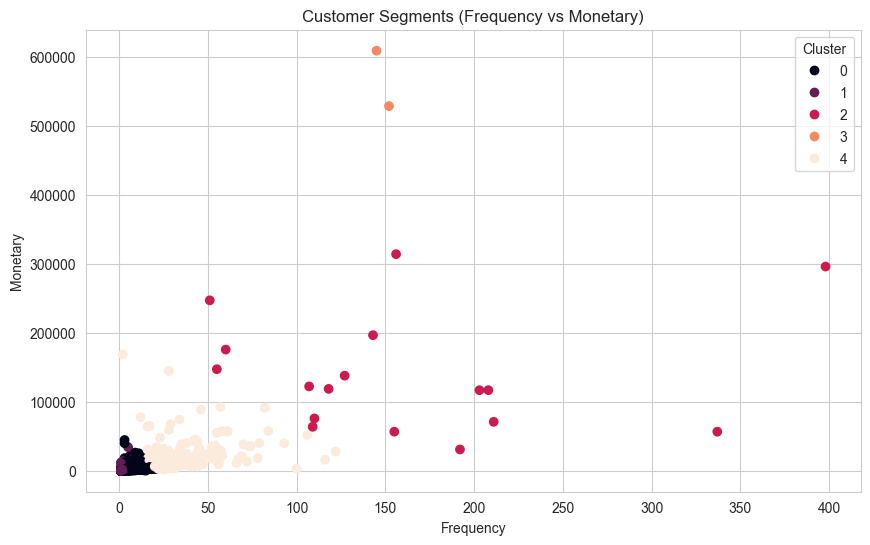

In [27]:
# TODO: Create scatter plot
# x-axis: Frequency
# y-axis: Monetary
# color: Cluster
# Include legend

# Plot Making
plt.scatter(rfm_df['Frequency'],rfm_df['Monetary'],c=rfm_df['cluster'])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segments (Frequency vs Monetary)')

# Legend Making
handles, labels = plt.gca().collections[0].legend_elements()
plt.legend(handles, labels, title="Cluster")

plt.show()

### Calculate Cluster Centers

Show the mean RFM values for each cluster

In [28]:
# TODO: Calculate mean Recency, Frequency, and Monetary for each cluster
# Replace with grouped DataFrame
cluster_summary =  (rfm_df.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].mean())

print("\n" + "="*80)
print("CLUSTER CENTERS (Mean RFM Values)")
print("="*80)
# TODO: Display cluster_summary

print(cluster_summary)
print("="*80)


CLUSTER CENTERS (Mean RFM Values)
            Recency   Frequency       Monetary
cluster                                       
0         73.795800    5.406190    2036.538555
1        469.925350    2.159150     752.396388
2         27.235294  161.176471  137806.995294
3          0.500000  148.500000  568712.085000
4         25.547771   32.509554   17330.192430


---
## Step 5: Interpret Segments and Provide Business Recommendations

### Segment 0: Occasional Low-Value Customers

**Customer Profile (3-5 sentences):**

Customers in Segment 0 have moderate Recency values, meaning they have not purchased very recently, along with low Frequency and relatively low Monetary values. This shows that they shop only once in a while and do not spend much money when they do. Compared to other segments, they bring in less revenue and are not very active customers. Their buying pattern suggests casual shoppers rather than regular customers.

In [29]:
# TODO: Calculate detailed statistics for Segment 0
# Show mean, median, min, max for R, F, M

segment_0 = rfm_df[rfm_df['cluster'] == 0][['Recency', 'Frequency', 'Monetary']]
segment_0_stats = segment_0.agg(['mean', 'median', 'min', 'max'])
print(segment_0_stats)

         Recency  Frequency      Monetary
mean     73.7958    5.40619   2036.538555
median   46.0000    4.00000   1180.230000
min       0.0000    1.00000      0.000000
max     283.0000   21.00000  44534.300000


### Segment 1: Lapsed Customers

**Customer Profile (3-5 sentences):**

Customers in Segment 1 have very high Recency values, meaning they have not made a purchase in a long time, along with very low Frequency and low Monetary values. This suggests that they rarely shop and spend very little overall. Compared to other segments, they provide the least value to the business and may no longer be active. These customers appear to be one time buyers or customers who have stopped engaging.

In [31]:
# TODO: Calculate detailed statistics for Segment 1

segment_1 = rfm_df[rfm_df['cluster'] == 1][['Recency', 'Frequency', 'Monetary']]
segment_1_stats = segment_1.agg(['mean', 'median', 'min', 'max'])
print(segment_1_stats)

          Recency  Frequency      Monetary
mean    469.92535    2.15915    752.396388
median  434.00000    1.00000    376.920000
min     266.00000    1.00000      0.000000
max     738.00000   29.00000  34095.260000


### Segment 2: Loyal Regular Customers

**Customer Profile (3-5 sentences):**

Customers in Segment 2 have low Recency values, meaning they have made purchases recently, along with high Frequency and moderate Monetary values. This indicates that they shop often and spend a steady amount over time. Compared to other segments, they are reliable customers who contribute consistent revenue. Their purchasing pattern shows loyalty without extremely high spending.

In [32]:
# TODO: Calculate detailed statistics for Segment 3

segment_2 = rfm_df[rfm_df['cluster'] == 2][['Recency', 'Frequency', 'Monetary']]
segment_2_stats = segment_2.agg(['mean', 'median', 'min', 'max'])
print(segment_2_stats)

           Recency   Frequency       Monetary
mean     27.235294  161.176471  137806.995294
median    2.000000  143.000000  118628.080000
min       0.000000   51.000000   30861.060000
max     372.000000  398.000000  313946.370000


### Segment 3: High-Value Power Customers

**Customer Profile (3-5 sentences):**

Customers in Segment 3 have very low Recency values, meaning they purchased extremely recently, along with very high Frequency and very high Monetary values. This shows that they shop very often and spend much more money than other customers. Compared to all other segments, they represent the highest business value. These customers are the most important group to retain.

In [33]:
# TODO: Calculate detailed statistics for Segment 3

segment_3 = rfm_df[rfm_df['cluster'] == 3][['Recency', 'Frequency', 'Monetary']]
segment_3_stats = segment_3.agg(['mean', 'median', 'min', 'max'])
print(segment_3_stats)

        Recency  Frequency    Monetary
mean        0.5      148.5  568712.085
median      0.5      148.5  568712.085
min         0.0      145.0  528602.520
max         1.0      152.0  608821.650


### Segment 4: Active Mid-Value Customers

**Customer Profile (3-5 sentences):**

Customers in Segment 4 have low Recency values, meaning they have purchased recently, along with moderate Frequency and moderate Monetary values. This suggests that they shop fairly often but do not spend as much as the highest value customers. Compared to lower value segments, they are more engaged and active. This group has potential to increase their spending over time.

In [34]:
# TODO: Calculate detailed statistics for Segment 4

segment_4 = rfm_df[rfm_df['cluster'] == 4][['Recency', 'Frequency', 'Monetary']]
segment_4_stats = segment_4.agg(['mean', 'median', 'min', 'max'])
print(segment_4_stats)

           Recency   Frequency      Monetary
mean     25.547771   32.509554   17330.19243
median    8.500000   28.000000   12136.33000
min       0.000000    2.000000    1820.44000
max     497.000000  122.000000  168472.50000


---
## Business Recommendations

### Recommendation 1: Retain and Reward High-Value Customers

**Which segment(s) does this target?** Segment 3 

**Recommendation (3-5 sentences):**

Customers in Segment 3 have very low Recency values along with very high Frequency and very high Monetary values. This shows they shop often and spend much more than other customers. The company should focus on retaining these customers through loyalty programs, exclusive discounts, or early access to new products. Personalized emails and rewards would help maintain their engagement and prevent them from leaving, keeping them satisfied.

### Recommendation 2: Encourage Growth in Active Mid-Value Customer

**Which segment(s) does this target?** Segment 4 and Segment 2 
**Recommendation (3-5 sentences):**

Customers in Segments 4 and 2 have low recency values along with moderate to high Frequency and Monetary values. This suggests they are active and already engaged but have room to spend more. The company should use targeted promotions such as bundle deals or small discounts to encourage larger purchases. These strategies could help move them closer to the high-value customer segment since they do have the potiental and just need to beat the recenty values.

### Recommendation 3: Re-Engage Inactive and Low-Value Customers

**Which segment(s) does this target?** Segment 0 and Segment 1

**Recommendation (3-5 sentences):**

Customers in Segments 0 and 1 have higher Recency values along with low Frequency and low Monetary values. This tells us a low engagement and limited spending. The company could attempt increasing engagement using limited-time discounts or reminder emails to bring these customers back. Simple messaging and small encoraguements may help others purchase items. However, these segments should be a lower priority compared to higher-value customers since they will not continuously provide a valuable income.

---
## Step 6: Submit Your Work

Before submitting:
1. Make sure all code cells run without errors
2. Verify you have:
   - RFM features properly calculated
   - Elbow method and silhouette score visualizations
   - Written justification for your k selection
   - Customer segment scatter plot
   - Descriptive names and profiles for each segment
   - Three specific business recommendations
3. Check that all visualizations display correctly

Then push to GitHub:
```bash
git add .
git commit -m 'completed customer segmentation assignment'
git push
```

Submit your GitHub repository link on the course platform.